# **Signature Verification using Siamese Networks**

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import zipfile
from tqdm import tqdm

%matplotlib inline

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Loss
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPool2D, Lambda

In [ ]:
# Dowload training data
!wget -O train.zip https://www.dropbox.com/s/qe64ouznpmi0gtf/train.zip?dl=0
!wget -O train_data.csv https://www.dropbox.com/s/stflog7pwq1kw7w/train_data.csv?dl=0

In [ ]:
# Download test data for model evaluation
!wget -O test.zip https://www.dropbox.com/s/61t4nkjad5gqa2g/test.zip?dl=0
!wget -O test_data.csv https://www.dropbox.com/s/zlu24renn1yr1ul/test_data.csv?dl=0

# **Explore example of signature** 

In [ ]:
train_zip = zipfile.ZipFile("train.zip")
train_zip.extractall()

test_zip = zipfile.ZipFile("test.zip")
test_zip.extractall()

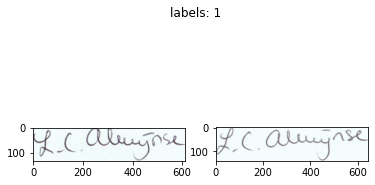

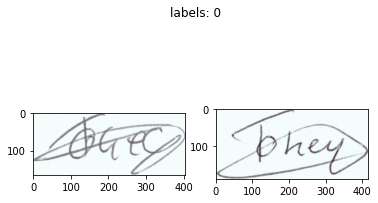

In [ ]:
train_df = pd.read_csv("train_data.csv")

indexes = np.random.choice(train_df.index, size = 2)

for ind in indexes:

  left_img = plt.imread(os.path.join("train", train_df.iloc[ind, 0:][0]))
  right_img = plt.imread(os.path.join("train", train_df.iloc[ind, 0:][1]))

  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.imshow(left_img)
  ax2.imshow(right_img)
  fig.suptitle("labels: {}".format(train_df.iloc[ind, 0:][2]), fontsize = 12)

# **Step 1: Data Preparation**
Using tensorflow Dataset to load image to Tensor


In [ ]:
def parse_img(filename, label):
  left_image_string = tf.io.read_file(filename[0])
  right_image_string = tf.io.read_file(filename[1])

  left_image = tf.io.decode_png(left_image_string, channels = 3)
  right_image = tf.io.decode_png(right_image_string, channels = 3)

  left_image = tf.image.resize(left_image, [28, 28])
  right_image = tf.image.resize(right_image, [28, 28])

  left_image /= 255.
  right_image /= 255.

  return [left_image, right_image], label

In [ ]:
def create_pair_dataset(df, train_dir):
  df["left_img"] = df.apply(lambda x: os.path.join(train_dir, x.left_img), axis = 1)
  df["right_img"] = df.apply(lambda x: os.path.join(train_dir, x.right_img), axis = 1)

  #filenames = df.iloc[0:, 0:2]
  filenames = df[["left_img", "right_img"]]
  labels = df["label"].astype("float")

  batch_size = 128

  def map_func(x, y):
    return {"left_input": x[0], "right_input": x[1]}, y

  dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
  #dataset = dataset.shuffle(len(filenames))
  dataset = dataset.map(parse_img, num_parallel_calls = 4)
  dataset = dataset.map(map_func, num_parallel_calls = 4)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(1)

  return dataset

In [ ]:
train_df = pd.read_csv("train_data.csv")
test_df = pd.read_csv("test_data.csv")

train_path = "train"
test_path = "test"

train_indexes = np.random.choice(train_df.index, size = int(len(train_df) * 0.8), replace = False)
val_indexes = np.array(train_df[~train_df.index.isin(train_indexes)].index)

train_data = train_df[train_df.index.isin(train_indexes)]
val_data = train_df[train_df.index.isin(val_indexes)]
test_data = test_df

train_dataset = create_pair_dataset(train_data, train_path)
val_dataset = create_pair_dataset(val_data, train_path)
test_dataset = create_pair_dataset(test_data, test_path)

print("training set: {}".format(len(train_data)))
print("validation set: {}".format(len(val_data)))
print("test set: {}".format(len(test_data)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

training set: 18564
validation set: 4642
test set: 5748


# **Step 2: Construct Siamese Networks**

In [ ]:
def initialize_base_model(width, height):
  input = Input(shape = (width, height, 3))
  x = Conv2D(32, (3, 3), activation = "relu")(input)
  x = MaxPool2D(2 ,2)(x)
  x = Conv2D(64, (3, 3), activation = "relu")(x)
  x = MaxPool2D(2 ,2)(x)
  x = Flatten()(x)
  x = Dense(1024, activation = "relu")(x)
  x = Dense(512, activation = "relu")(x)
  x = Dense(128, activation = "relu")(x)
    
  return Model(inputs = input, outputs = x)

In [ ]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

In [ ]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis = 1, keepdims = True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [ ]:
base_model = initialize_base_model(28, 28)

input_a = Input(shape = (28, 28, 3), name = "left_input")
input_b = Input(shape = (28, 28, 3), name = "right_input")

output_a = base_model(input_a)
output_b = base_model(input_b)

output = Lambda(euclidean_distance, output_shape = eucl_dist_output, name = "euclidean_distance")([output_a, output_b])

model = Model(inputs = [input_a, input_b], outputs = output, name = "conv_output")

model.compile(optimizer = "adam", loss = contrastive_loss)
model.fit(train_dataset, validation_data = val_dataset, epochs = 10)

Epoch 1/10
146/146 [==============================] - 138s 938ms/step - loss: 0.2111 - val_loss: 0.1335
Epoch 2/10
146/146 [==============================] - 136s 936ms/step - loss: 0.1624 - val_loss: 0.1117
Epoch 3/10
146/146 [==============================] - 139s 954ms/step - loss: 0.1188 - val_loss: 0.0973
Epoch 4/10
146/146 [==============================] - 137s 937ms/step - loss: 0.0929 - val_loss: 0.1375
Epoch 5/10
146/146 [==============================] - 136s 933ms/step - loss: 0.0789 - val_loss: 0.0711
Epoch 6/10
146/146 [==============================] - 137s 938ms/step - loss: 0.0647 - val_loss: 0.0809
Epoch 7/10
146/146 [==============================] - 136s 935ms/step - loss: 0.0811 - val_loss: 0.0722
Epoch 8/10
146/146 [==============================] - 136s 934ms/step - loss: 0.0668 - val_loss: 0.0652
Epoch 9/10
146/146 [==============================] - 136s 931ms/step - loss: 0.0573 - val_loss: 0.0539
Epoch 10/10
146/146 [==============================] - 136s 931m

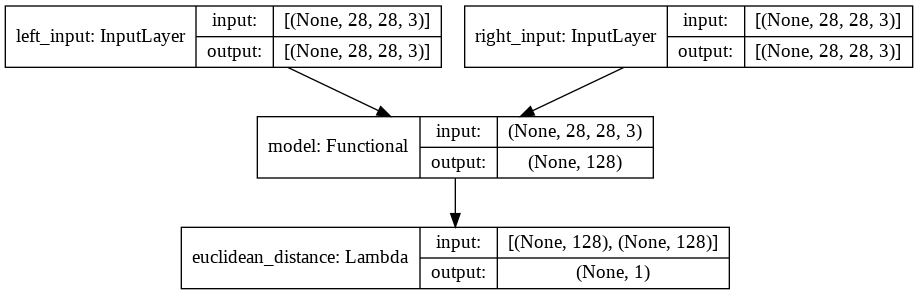

In [ ]:
plot_model(model, show_shapes = True, show_layer_names = True)

# **Step 3: Model Evaluation**

In [ ]:
def compute_accuracy(y_true, y_pred):
  threshold = 0.4
  prediction = y_pred <= threshold
  return np.mean(prediction.ravel() == np.array(y_true))

In [ ]:
# Train Accuracy
train_euclidean_distance = model.predict(train_dataset, verbose = 1)
compute_accuracy(train_data["label"], train_euclidean_distance )

146/146 [==============================] - 86s 592ms/step


0.947317388493859

In [ ]:
# Test Accuracy
test_euclidean_distance = model.predict(test_dataset, verbose = 1)
compute_accuracy(test_data["label"], test_euclidean_distance)

45/45 [==============================] - 29s 644ms/step


0.9693806541405706

In [ ]:
sns.set_theme()
train_data["euclidean distance"] = train_euclidean_distance
#train_result = train_data.rename(columns = {"similarity_score": "euclidean distance"})
train_result = train_data
train_result["Label"] = train_result.apply(lambda x: "Genuine" if x.label == 1 else "Forged", axis = 1)
train_result.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,left_img,right_img,label,euclidean distance,Label
0,train/068/09_068.png,train/068_forg/03_0113068.PNG,0,1.957026,Forged
1,train/068/09_068.png,train/068_forg/01_0124068.PNG,0,2.367050,Forged
2,train/068/09_068.png,train/068_forg/02_0124068.PNG,0,2.979389,Forged
3,train/068/09_068.png,train/068_forg/01_0113068.PNG,0,1.757830,Forged
5,train/068/09_068.png,train/068_forg/04_0113068.PNG,0,1.873825,Forged


Text(0.5, 1.0, 'Euclidean Distance Distribution')

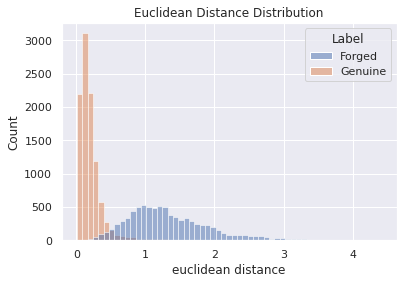

In [ ]:
sns.histplot(x = "euclidean distance", data = train_result, hue = "Label").set_title("Euclidean Distance Distribution")